In [1]:
# instgalamos e importamos las librerías que necesitamos
!pip install pandas matplotlib
!pip install pandas matplotlib seaborn

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
import scipy.stats as stats
from scipy.stats import chi2_contingency, ttest_ind
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kruskal

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

import warnings
warnings.filterwarnings("ignore")


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Fase 1: Exploración y Limpieza

1.Exploración Inicial:
Realiza una exploración inicial de los datos para identificarposibles problemas, como valores nulos, atípicos o datosfaltantes en las columnas relevantes.
Utiliza funciones de Pandas para obtener informaciónsobre la estructura de los datos, la presencia de valoresnulos y estadísticas básicas de las columnas involucradas.
Une los dos conjuntos de datos de la forma más eficiente.

In [2]:
# Cargar los csv como dataframes
df_CLH = pd.read_csv("Customer Loyalty History.csv", index_col=None)
df_CFA = pd.read_csv("Customer Flight Activity.csv", index_col=None)

In [3]:
# Función para exploración general de datos
def exploracion_datos(df):
    print('_____________ INFORMACIÓN GENERAL DEL DATAFRAME ____________\n')
    print(df.info())
    
    print('___________________ FORMA DEL DATAFRAME ____________________\n')
    print(f"El número de filas que tenemos es de {df.shape[0]}.\nEl número de columnas es de {df.shape[1]}\n")
    
    print('_______________ NULOS, ÚNICOS Y DUPLICADOS _________________\n')
    print('La cantidad de valores NULOS por columna es de:\n')
    print(df.isnull().sum())
    print('____________________________________________________________\n')

    print('El porcentaje de valores NULOS por columna es de:\n')
    porcentaje_nulos = (df.isnull().sum() / df.shape[0]) * 100
    porcentaje_nulos = porcentaje_nulos.round(2)
    print(porcentaje_nulos)
    print('____________________________________________________________\n')

    print('La cantidad de valores ÚNICOS por columna es de:\n')
    for columna in df.columns:
        cantidad_unicos = df[columna].nunique()
        print(f'La columna {columna} tiene {cantidad_unicos} valores únicos.')
    print('____________________________________________________________\n')

    print('La cantidad de valores DUPLICADOS por columna es de:\n')
    for columna in df.columns:
        cantidad_duplicados = df.duplicated(subset=columna).sum()
        print(f'La columna {columna} tiene {cantidad_duplicados} valores duplicados.')
    print('____________________________________________________________\n')
    
    print('____________________ RESUMEN ESTADÍSTICO ____________________\n')
    print('___________________ Variables Numéricas _____________________\n')
    if df.select_dtypes(include=[float, int]).empty:
        print("No hay variables numéricas para mostrar el resumen estadístico.")
    else:
        print(df.describe().T)
    print('____________________________________________________________\n')
    print('___________________ Variables Categóricas _____________________\n')
    if df.select_dtypes(include=[object]).empty:
        print("No hay variables categóricas para mostrar el resumen estadístico.")
    else:
        print('__________________ Variables Categóricas ____________________\n')
        print(df.describe(include='object').T)

In [4]:
# Llamamos a la función para explorar el dataframe df_CLH 
exploracion_datos(df_CLH)

_____________ INFORMACIÓN GENERAL DEL DATAFRAME ____________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Loyalty Number      16737 non-null  int64  
 1   Country             16737 non-null  object 
 2   Province            16737 non-null  object 
 3   City                16737 non-null  object 
 4   Postal Code         16737 non-null  object 
 5   Gender              16737 non-null  object 
 6   Education           16737 non-null  object 
 7   Salary              12499 non-null  float64
 8   Marital Status      16737 non-null  object 
 9   Loyalty Card        16737 non-null  object 
 10  CLV                 16737 non-null  float64
 11  Enrollment Type     16737 non-null  object 
 12  Enrollment Year     16737 non-null  int64  
 13  Enrollment Month    16737 non-null  int64  
 14  Cancellation Year   2067 non-null   floa

In [5]:
# Vemos que aspecto tienen las 5 primeras columnas del dataframe df_CLH 
df_CLH.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN


In [6]:
# Llamamos a la función para explorar el dataframe df_CFA
exploracion_datos(df_CFA)

_____________ INFORMACIÓN GENERAL DEL DATAFRAME ____________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Loyalty Number               405624 non-null  int64  
 1   Year                         405624 non-null  int64  
 2   Month                        405624 non-null  int64  
 3   Flights Booked               405624 non-null  int64  
 4   Flights with Companions      405624 non-null  int64  
 5   Total Flights                405624 non-null  int64  
 6   Distance                     405624 non-null  int64  
 7   Points Accumulated           405624 non-null  float64
 8   Points Redeemed              405624 non-null  int64  
 9   Dollar Cost Points Redeemed  405624 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 30.9 MB
None
___________________ FORMA DEL DATAFRAME ____________________

E

In [7]:
# Vemos que aspecto tienen las 5 primeras columnas del dataframe df_CFA
df_CFA.head()

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0
2,100140,2017,1,6,0,6,1200,120.0,0,0
3,100214,2017,1,0,0,0,0,0.0,0,0
4,100272,2017,1,0,0,0,0,0.0,0,0


In [8]:
"""Unión de los dataframes: como quiero que me devuelva solo las filas donde hay una coincidencia en ambos dataframes en la columna Loyalty Number he utilizado un inner."""
merged_df = pd.merge(df_CLH, df_CFA, on='Loyalty Number', how='inner')

In [9]:
# Comprobamos que se han unido correctamente
print(f'La cantidad de columnas ahora es de: {merged_df.shape[1]}\n')

La cantidad de columnas ahora es de: 25



In [10]:
# Vemos que aspecto tiene nuestro nuevo dataframe mergeado
merged_df.sample(5)

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
372431,856818,Canada,Quebec,Montreal,H2Y 2W2,Female,Bachelor,70376.0,Divorced,Star,9045.11,Standard,2018,5,NaN,NaN,2018,12,14,0,14,1078,107.0,0,0
65598,809733,Canada,Quebec,Montreal,H2Y 4R4,Female,Bachelor,77335.0,Married,Aurora,8639.09,Standard,2012,9,NaN,NaN,2017,6,5,5,10,870,87.0,0,0
41786,452417,Canada,Alberta,Edmonton,T9G 1W3,Male,Bachelor,59382.0,Married,Aurora,6457.56,Standard,2014,6,NaN,NaN,2017,3,7,0,7,2135,213.0,0,0
186180,144328,Canada,Ontario,Ottawa,K1G 4Z0,Male,College,NaN,Single,Nova,7449.86,Standard,2013,2,NaN,NaN,2018,2,0,0,0,0,0.0,0,0
159187,617008,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,85867.0,Single,Nova,5278.18,Standard,2012,7,NaN,NaN,2018,8,0,0,0,0,0.0,0,0


Fase 1: Exploración y Limpieza

2.Limpieza de Datos:
Elimina o trata los valores nulos, si los hay, en lascolumnas clave para asegurar que los datos esténcompletos.
Verifica la consistencia y corrección de los datos paraasegurarte de que los datos se presenten de formacoherente.
Realiza cualquier ajuste o conversión necesaria en lascolumnas (por ejemplo, cambiar tipos de datos) paragarantizar la adecuación de los datos para el análisisestadístico.

In [11]:
# Eliminamos las columnas "Cancelation Year" y "Cancelation Month" porque tienen un altgo porcentaje de nulos y no son relevantes para nuestro análisis. También "Country" porque es el mismo para todos los registros: Canadá
merged_df = merged_df.drop(columns=['Cancellation Year', 'Cancellation Month', 'Country'])

# Verificamos las columnas después de eliminar. Vemos que las que hemos eliminado ya no aparecen en el listado
print("Columnas después de eliminar:")
print(merged_df.columns)

Columnas después de eliminar:
Index(['Loyalty Number', 'Province', 'City', 'Postal Code', 'Gender',
       'Education', 'Salary', 'Marital Status', 'Loyalty Card', 'CLV',
       'Enrollment Type', 'Enrollment Year', 'Enrollment Month', 'Year',
       'Month', 'Flights Booked', 'Flights with Companions', 'Total Flights',
       'Distance', 'Points Accumulated', 'Points Redeemed',
       'Dollar Cost Points Redeemed'],
      dtype='object')


In [12]:
# Hacemos función para comparar la media y la mediana de una variable. En una distribución simétrica y sin valores atípicos, la media y la mediana deberían ser aproximadamente iguales
def cal_min_median(df, columna):
    media = df[columna].mean()
    mediana = df[columna].median()
    return media, mediana

In [13]:
# Comparamos la media y la mediana de la columna "Salary" para ver si imputamos sus nulos con la media o la mediana
cal_min_median(merged_df, "Salary")

(79268.82595262615, 73479.0)

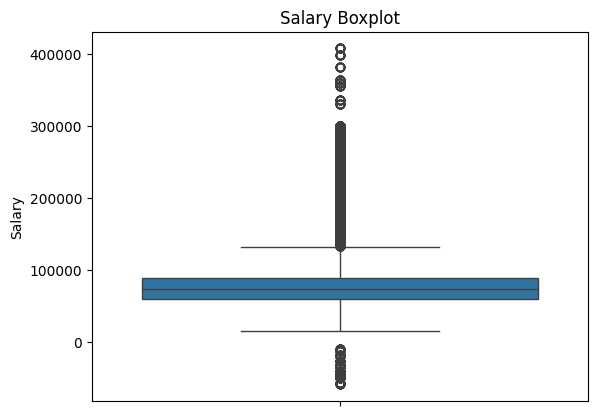

In [14]:
# También podemos comprobar si existe una distribución simétrica o no de forma visual haciendo un boxplot. En este caso vemos que no se trata de una distribución simétrica, pues hay muchos outliers
sns.boxplot(y=merged_df["Salary"])
plt.title("Salary Boxplot")
plt.ylabel("Salary")
plt.show()


In [15]:
# Función para imputar los nulos con la mediana. 
def null_to_median(df, columna):
    mediana = df[columna].median()
    df[columna] = df[columna].fillna(mediana)
    return df

In [16]:
# Como la media y la mediana son bastante diferentes y la distribución no es simétrica vamos a optar imputar con la mediana
null_to_median(merged_df, "Salary")

# Comprobamos si se ha hecho correctamente
merged_df["Salary"].isnull().sum()

0

In [17]:
# Función para pasar float a integer en el caso de la columna "Salary" 
def float_to_int(df, columns):
    for col in columns:
        df[col] = df[col].astype(int)
    
    return df

In [18]:
# Pasamos el tipo de dato de float a integer en el caso de "Salary" porque los valores de esta columna no tienen decimales
col_float_to_int = ["Salary"]
float_to_int(merged_df, col_float_to_int)

# Comprobamos que se ha hecho correctamente
merged_df["Salary"].dtype

dtype('int32')

In [19]:
# Diccionario para mapear números de mes a nombres de mes
month_dict = {
    1: 'January',
    2: 'Febrary',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'Jun',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
    }

# Convertimos los números de mes a nombres de mes utilizando .map para que los datos de esta columna resulten más fáciles de interpretar
merged_df['Month'] = merged_df['Month'].map(month_dict)

# Vemos si se ha hecho correctamente
merged_df['Month']

0           January
1           Febrary
2             March
3             April
4           October
            ...    
405619       August
405620    September
405621      October
405622     November
405623     December
Name: Month, Length: 405624, dtype: object

In [20]:
# Función para eliminar regkistros (filas) duplicadas
def drop_dup(df):
    # Verificar filas duplicadas basadas en todas las columnas
    dup_rows = df.duplicated(keep=False)

    # Filtrar las filas duplicadas
    dup = df[dup_rows]

    # Eliminar todas las filas duplicadas
    no_dup_df = df.drop_duplicates(keep=False)

    return no_dup_df, dup

In [21]:
# Llamamos a la función, que nos devuelve el dataframe sin duplicados y la variable que contiene el número de filas duplicadas
no_dup_df, dup = drop_dup(merged_df)

In [22]:
# Vemos cuántas filas estaban duplicadas
print(f'La cantidad de filas duplicadas es de: {dup.shape[0]}\n')

La cantidad de filas duplicadas es de: 3712



In [23]:
# El dataframe sin duplicados tiene menos registros, así que las duplicidades se han eliminado correctamente. A partir de ahora usaremos este dataframe para aplicar las siguientes acciones. 
print(f'La cantidad de filas del nuevo dataframe sin duplicados es de: {no_dup_df.shape[0]}\n')
print(f'La cantidad de columnas del nuevo dataframe sin duplicados es de: {no_dup_df.shape[1]}\n')

La cantidad de filas del nuevo dataframe sin duplicados es de: 401912

La cantidad de columnas del nuevo dataframe sin duplicados es de: 22



In [24]:
# Función para chequear si hay valores negativos en las columnas numéricas
def neg_values(df):
    neg_counts = {}

    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            neg_counts[column] = (df[column] < 0).sum()

    return neg_counts


# Llamar a la función para contar valores negativos
neg_counts = neg_values(no_dup_df)

# Mostrar los resultados
print("Número de valores negativos por columna:")
for column, count in neg_counts.items():
    print(f"Columna '{column}': {count} valores negativos")

Número de valores negativos por columna:
Columna 'Loyalty Number': 0 valores negativos
Columna 'Salary': 480 valores negativos
Columna 'CLV': 0 valores negativos
Columna 'Enrollment Year': 0 valores negativos
Columna 'Enrollment Month': 0 valores negativos
Columna 'Year': 0 valores negativos
Columna 'Flights Booked': 0 valores negativos
Columna 'Flights with Companions': 0 valores negativos
Columna 'Total Flights': 0 valores negativos
Columna 'Distance': 0 valores negativos
Columna 'Points Accumulated': 0 valores negativos
Columna 'Points Redeemed': 0 valores negativos
Columna 'Dollar Cost Points Redeemed': 0 valores negativos


In [25]:
#Sustituimos valores negativos que hemos detectado en la columna 'Salary' por valores positivos
no_dup_df.loc[no_dup_df['Salary'] < 0, 'Salary'] = no_dup_df['Salary'].abs()

#Comprobamos que ya no hay valores negativos
no_dup_df[no_dup_df['Salary'] < 0]

,Loyalty Number,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed


In [26]:
#Guardamos el csv con los datos limpios
no_dup_df.to_csv('no_dup_df.csv', index=False)

Fase 2: Visualización

Usando las herramientas de visualización que has aprendido duranteeste módulo, contesta a las siguientes gráficas usando la mejor gráficaque consideres:

1.¿Cómo se distribuye la cantidad de vuelos reservados por mes durante el año?

Como vemos en el histograma a continuación, los meses en los que se reservan más vuelos son los de verano, junio, julio y agosto. Seguidos de diciembre, mes de la Navidad.

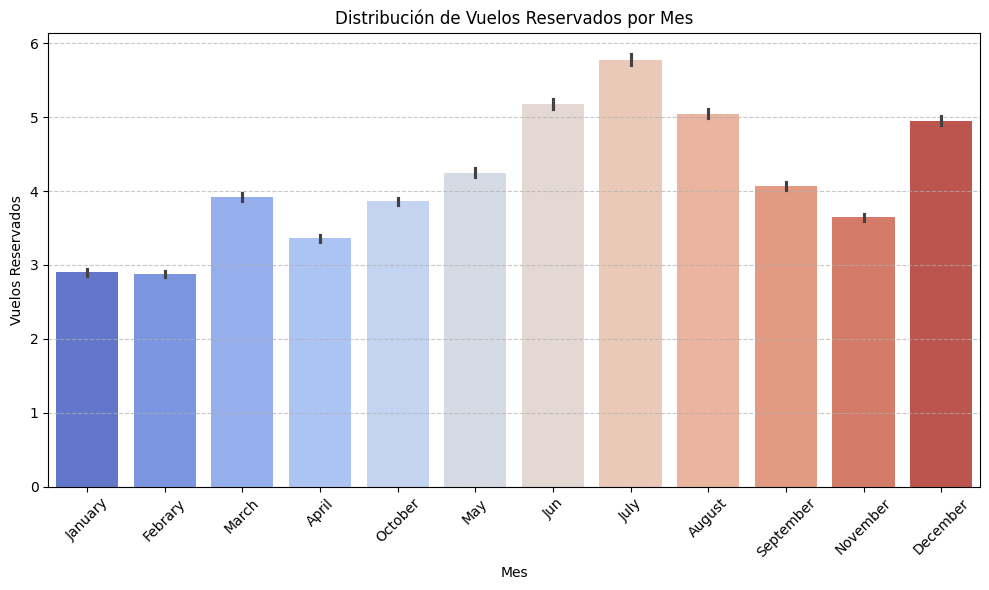

In [27]:
# Creamos un histograma
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Flights Booked', data=no_dup_df, palette='coolwarm', dodge=False, legend=False)
plt.xlabel('Mes')
plt.ylabel('Vuelos Reservados')
plt.title('Distribución de Vuelos Reservados por Mes')
plt.xticks(rotation=45)
plt.tight_layout()  # Asegura que los elementos no se solapen
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

2.¿Existe una relación entre la distancia de los vuelos y los puntos acumulados por los clientes?

Como los puntos en el diagrama de dispersión muestran un patrón lineal y el coeficiente de correlación es cercano a 1 o -1, podemos afirmar que existe una relación fuerte entre la distancia y los puntos acumulados. 

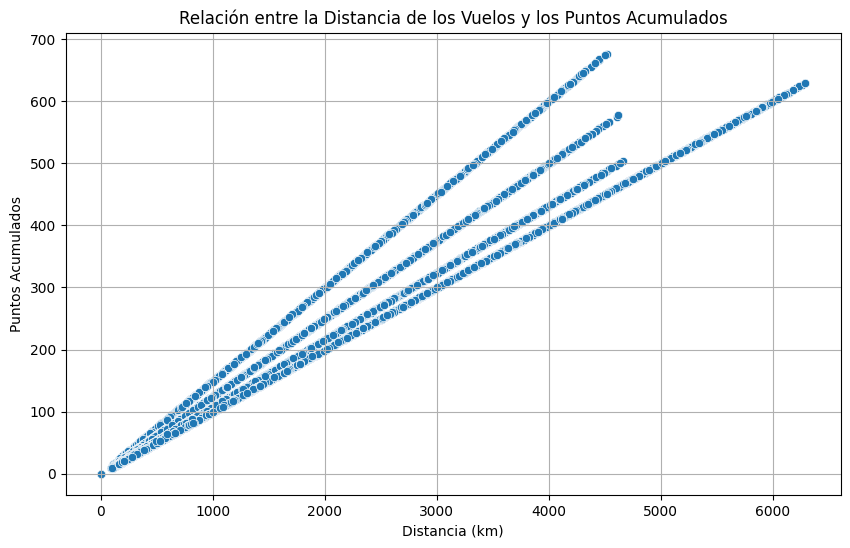

Coeficiente de correlación: 0.9945277510679296


In [28]:
# Crear el diagrama de dispersión con seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Distance', y='Points Accumulated', data=no_dup_df)
plt.xlabel('Distancia (km)')
plt.ylabel('Puntos Acumulados')
plt.title('Relación entre la Distancia de los Vuelos y los Puntos Acumulados')
plt.grid(True)
plt.show()

# Calcular el coeficiente de correlación
correlation = no_dup_df['Distance'].corr(no_dup_df['Points Accumulated'])
print(f'Coeficiente de correlación: {correlation}')

3.¿Cuál es la distribución de los clientes por provincia o estado?

Las provincias con más clientes son Ontario, British Columbia y Quebec. Las provincias con menos clientes son Newfoundland, Yukon y Prince Edward Island.

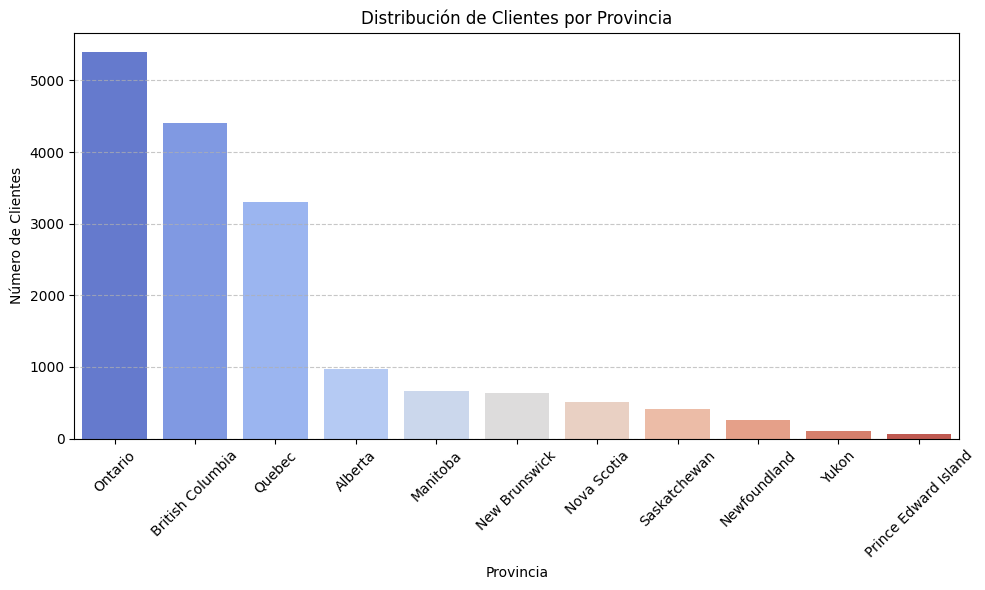

In [29]:
# Primero eliminamos las duplicidades de la 'Loyalty Number', que es la que identifica a cada cliente para que tenga en cuenta a cada cliente una sola vez. Emplearemos este nuevo dataframee también en los siguientes gráficos. 
unique_customers_df = no_dup_df.drop_duplicates(subset='Loyalty Number')

# Agrupamos por 'Province', contamos y ordenamos los clientes únicos
customer_distribution = unique_customers_df['Province'].value_counts().reset_index()
customer_distribution.columns = ['Province', 'Customer Count']

# Crear el gráfico de barras con seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Province', y='Customer Count', data=customer_distribution, palette='coolwarm', dodge=False, legend=False)
plt.xlabel('Provincia')
plt.ylabel('Número de Clientes')
plt.title('Distribución de Clientes por Provincia')
plt.xticks(rotation=45)
plt.tight_layout()  # Asegura que los elementos no se solapen
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

4.¿Cómo se compara el salario promedio entre los diferentes niveles educativos de los clientes?

Como podemos observar en el gráfico de barras de abajo los salarios más elevados se corresponden con los niveles educativos más altos, por lo que podemos afirmamos que hay una relación directamente proporcional entre las dos variables. 

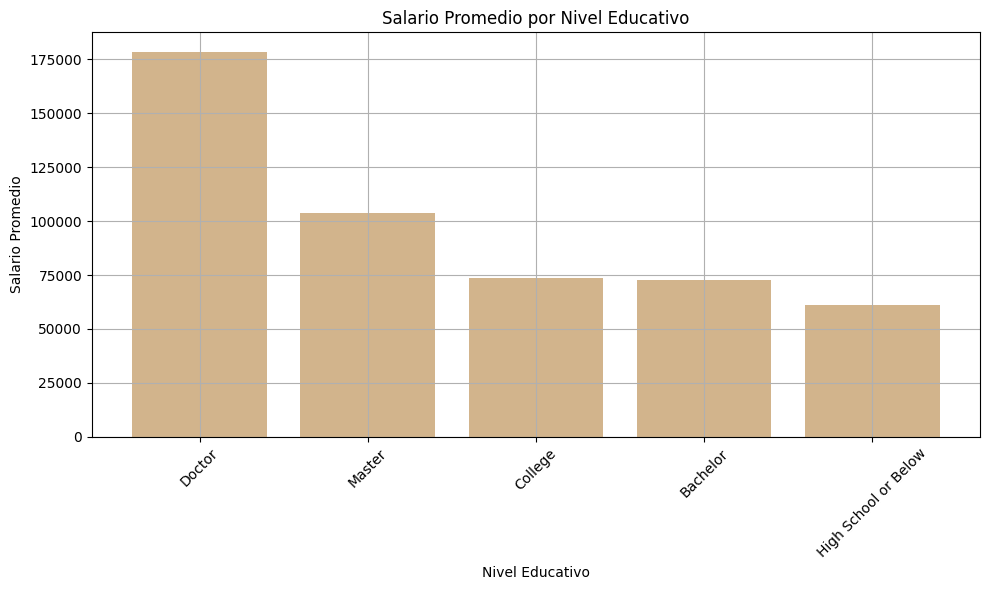

In [30]:
# Calculamos primero el salario promedio por nivel educativo
salariy_per_education = unique_customers_df.groupby('Education')['Salary'].mean().reset_index()

# Ordenamos los resultados
salariy_per_education = salariy_per_education.sort_values(by='Salary', ascending=False)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.bar(salariy_per_education['Education'], salariy_per_education['Salary'], color='tan')
plt.xlabel('Nivel Educativo')
plt.ylabel('Salario Promedio')
plt.title('Salario Promedio por Nivel Educativo')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

5.¿Cuál es la proporción de clientes con diferentes tipos de tarjetas de fidelidad?

El 45,7% de los clientes tienen la tarjeta "Star", seguidos del 33,9% que tienen la Nova y el 20,5% cuentan con la Aurora. 

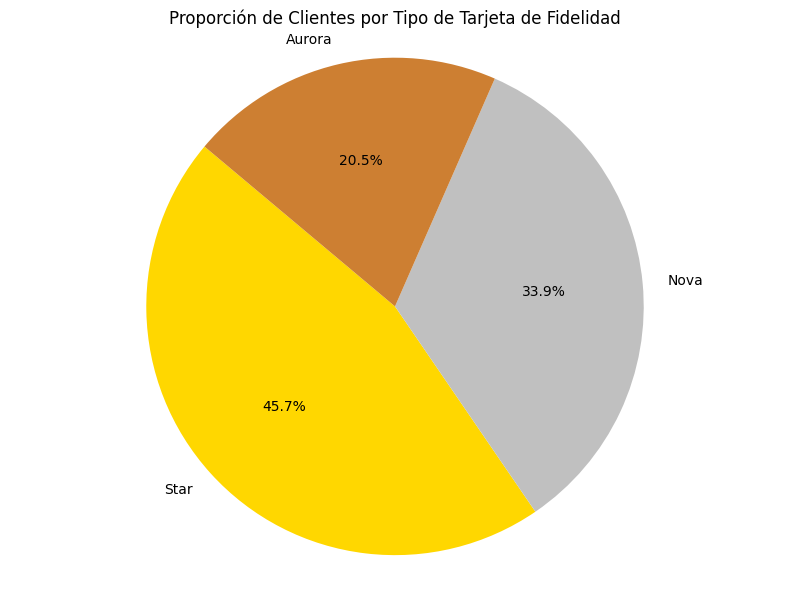

In [31]:
# Contamos el número de cada tipo de tarjeta de fidelidad
counts = unique_customers_df['Loyalty Card'].value_counts()

# Calculamos la proporción
proporciones = counts / counts.sum()

# Configuramos el gráfico circular
plt.figure(figsize=(8, 6))
colors = ['#FFD700', '#C0C0C0', '#CD7F32']  # Oro, Plata, Bronce
plt.pie(proporciones, labels=proporciones.index, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Proporción de Clientes por Tipo de Tarjeta de Fidelidad')
plt.axis('equal')  
plt.tight_layout()
plt.show()

6.¿Cómo se distribuyen los clientes según su estado civil y género?
Como puede observarse en el gráfico de barras apiladas a continuación existe una mayor número de clientes casados, seguidos de solteros y por último divorciados. En los tres casos el número de hombres y mujeres es muy similar, siendo el de mujeres ligeramente más elevado. 

<Figure size 1000x600 with 0 Axes>

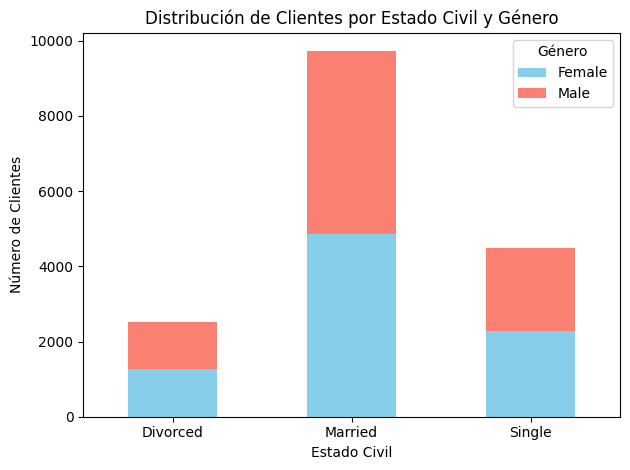

In [32]:
# Contar el número de clientes por estado civil y género
counts = unique_customers_df.groupby(['Marital Status', 'Gender']).size().unstack()

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
plt.title('Distribución de Clientes por Estado Civil y Género')
plt.xlabel('Estado Civil')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=0)
plt.legend(title='Género')
plt.tight_layout()
plt.show()

Fase 3: Evaluación de Diferencias en Reservas de Vuelos por Nivel Educativo
Objetivo del Ejercicio:
Utilizando un conjunto de datos que hemoscompartido, se busca evaluar si existen diferencias significativas en elnúmero de vuelos reservados según el nivel educativo de los clientes.Para ello, los pasos que deberas seguir son:

1. Preparación de Datos:
Filtra el conjunto de datos para incluir únicamente las columnas relevantes: 'Flights Booked' y 'Education'.

In [33]:
# Filtramos el DataFrame para incluir únicamente las columnas 'Flights Booked' y 'Education'
filtered_df = unique_customers_df[['Flights Booked', 'Education']]

filtered_df.sample(10)


,Flights Booked,Education
125592,0,Bachelor
391872,4,College
238728,0,Bachelor
131376,9,Bachelor
169080,0,Bachelor
248328,7,Doctor
362280,0,Bachelor
92592,1,College
208440,1,Bachelor
368064,6,Bachelor


2. Análisis Descriptivo:
Agrupa los datos por nivel educativo y calcula estadísticasdescriptivas básicas (como el promedio, la desviaciónestandar, los percentiles) del número de vuelos reservadospara cada grupo.

In [34]:
# Agrupamos los datos por nivel educativo y calculamos estadísticas descriptivas básicas
grouped_stats = filtered_df.groupby('Education')['Flights Booked'].describe()

# Mostramos las estadísticas descriptivas
print(grouped_stats)

                        count      mean       std  min  25%  50%  75%   max
Education                                                                  
Bachelor              10457.0  2.879698  4.036400  0.0  0.0  0.0  6.0  21.0
College                4233.0  2.904796  4.035190  0.0  0.0  0.0  6.0  21.0
Doctor                  732.0  3.016393  4.253558  0.0  0.0  0.0  6.0  20.0
High School or Below    780.0  2.935897  4.117777  0.0  0.0  0.0  6.0  18.0
Master                  507.0  2.980276  4.250506  0.0  0.0  0.0  6.0  19.0


A priori no existe una gran diferencia no en las medias,  ni en las desviaciones estándar ni en la distribución por percentiles. 

3. Prueba Estadística:
Realiza una prueba de hipótesis para determinar si existeuna diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.

In [35]:
"""Como queremos comparar diferentes conjuntos de datos, es útil saber si estos datos siguen una distribución normal o no como primer paso en una prueba de hipótesis"""
normality_results = filtered_df.groupby('Education')['Flights Booked'].apply(lambda x: shapiro(x))

# Mostramos los resultados de la prueba de normalidad
print("Prueba de normalidad (Shapiro-Wilk):")
for education, result in normality_results.items():
    print(f"{education}: Estadístico W = {result[0]}, p-valor = {result[1]}")

Prueba de normalidad (Shapiro-Wilk):
Bachelor: Estadístico W = 0.7369598274248086, p-valor = 1.214237961166054e-83
College: Estadístico W = 0.7417651561883769, p-valor = 5.567005723664218e-63
Doctor: Estadístico W = 0.7309338453793923, p-valor = 1.0030558956066386e-32
High School or Below: Estadístico W = 0.7330506526654299, p-valor = 1.5752884876910315e-33
Master: Estadístico W = 0.7314514114149777, p-valor = 8.673573069152637e-28


Como podemos observar todos los grupos tienen p-valores muy pequeños (cerca de 0), lo que indica que rechazamos la hipótesis nula de normalidad. Esto sugiere que los datos no siguen una distribución normal.

In [36]:
"""A continuación vamos a realizar una verificación de Homogeneidad de Varianzas con el test de Levene, también muy útil cuando comparamos diferentes conjuntos de datos"""
# Agrupar los datos por nivel educativo
education_groups = [group for name, group in filtered_df.groupby('Education')['Flights Booked']]

# Realizar la prueba de Levene para la homogeneidad de varianzas
levene_result = levene(*education_groups)

# Mostrar el resultado de la prueba de Levene
print("\nPrueba de homogeneidad de varianzas (Levene):")
print(f"Estadístico W = {levene_result.statistic}, p-valor = {levene_result.pvalue}")


Prueba de homogeneidad de varianzas (Levene):
Estadístico W = 0.2812424408347339, p-valor = 0.890285787700654


El p-valor es 0.890285787700654, que es mayor que 0.05, lo que indica que aceptamos la hipótesis nula de homogeneidad de varianzas. Esto sugiere que las varianzas entre los grupos son iguales.

Como según los resultados del test de Levene las varianzas son homogéneas pero los resultados del test de Shapiro-Wilk indican que los datos no siguen una distribución normal optamos por usar la prueba no paramétrica de Kruskal-Wallis.

In [37]:
"""Realizamos la prueba de Kruskal-Wallis
Hipótesis nula (H0): Las distribuciones de vuelos reservados son las mismas entre los diferentes niveles educativos.
Hipótesis alternativa (H1): La distribución de vuelos reservados es diferente entre los niveles educativos."""

kruskal_result = kruskal(*education_groups)

# Mostramos el resultado de la prueba de Kruskal-Wallis
print('Estadístico H:', kruskal_result.statistic)
print('Valor p:', kruskal_result.pvalue)

# Interpretamos el resultado
alpha = 0.05
if kruskal_result.pvalue < alpha:
    print("Rechazamos la hipótesis nula: Existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.")
else:
    print("No rechazamos la hipótesis nula: No existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.")

Estadístico H: 0.25849593191102915
Valor p: 0.992333467293413
No rechazamos la hipótesis nula: No existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.
